In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import trapezoid as trapz

In [6]:
# repeat_trial, T16, S7
og_df = pd.read_csv('../out_LED.csv')
df = og_df[ og_df['repeat_trial'].isin([0,2]) | og_df['repeat_trial'].isna() ]
session_type = 7    
df = df[ df['session_type'].isin([session_type]) ]
training_level = 16
df = df[ df['training_level'].isin([training_level]) ]

# Take LED OFF
df_led_off = df[df['LED_trial'] == 0]

# remove ILD 16, -16
df_led_off = df_led_off[ ~df_led_off['ILD'].isin([16, -16]) ]


In [7]:
# take RT - t_stim < 1s
df_led_off = df_led_off[df_led_off['timed_fix'] - df_led_off['intended_fix'] < 1]

# remove trunc aborts
data_df_led_off_with_aborts = df_led_off[ ~( (df_led_off['abort_event'] == 3) & (df_led_off['timed_fix'] < 0.3) ) ]

# rename columns
data_df_led_off_with_aborts = data_df_led_off_with_aborts.rename(
    columns={'timed_fix': 'rt', 'intended_fix': 't_stim'}
)


In [25]:
import scipy.io

# Load the .mat file
data = scipy.io.loadmat('hist_data.mat')

# Assuming your .mat file contains variables 'xx' and 'hcs'
xx = data['xx'].squeeze()  # Ensure xx is a 1D array
hcs = data['hcs']          # hcs might be a 2D array or a cell-like structure

ABL_test = [20, 40, 60]
ILD_test = [1, 2, 4, 8]

# for ABL_i in range(3):
#     for ILD_i in range(4):
#         ABL = ABL_test[ABL_i]
#         ILD = ILD_test[ILD_i]

#         data_pd = data_df_led_off_with_aborts[(data_df_led_off_with_aborts['ABL'] == ABL) & (data_df_led_off_with_aborts['ILD'].isin([ILD, -ILD]))]
#         data_rt = data_pd['rt'] - data_pd['t_stim']
#         bins = np.arange(-2, 2, 0.02)
#         t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])
#         data_rt_hist, _ = np.histogram(data_rt, density=True, bins=bins)

#         plt.figure()
#         # mine
#         plt.plot(t_pts, data_rt_hist, label=f'raga', color='b')
#         # Juan
#         plt.plot(xx[:-1], hcs[ABL_i, ILD_i].squeeze(), color='r', ls='--', label='juan')
#         plt.legend()
        
#         area_juan = trapz(hcs[ABL_i, ILD_i].squeeze(), xx[:-1])
#         area_raga = trapz(data_rt_hist, t_pts)
        
#         plt.title(f'ABL={ABL_test[ABL_i]}, ILD={ILD_test[ILD_i]}, Juan Area = {area_juan:.2f}, Raga Area = {area_raga: .2f}')

#         plt.show()


/tmp/ipykernel_1715718/3468562819.py:33: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  area_juan = trapz(hcs[ABL_i, ILD_i].squeeze(), xx[:-1])
/tmp/ipykernel_1715718/3468562819.py:34: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  area_raga = trapz(data_rt_hist, t_pts)


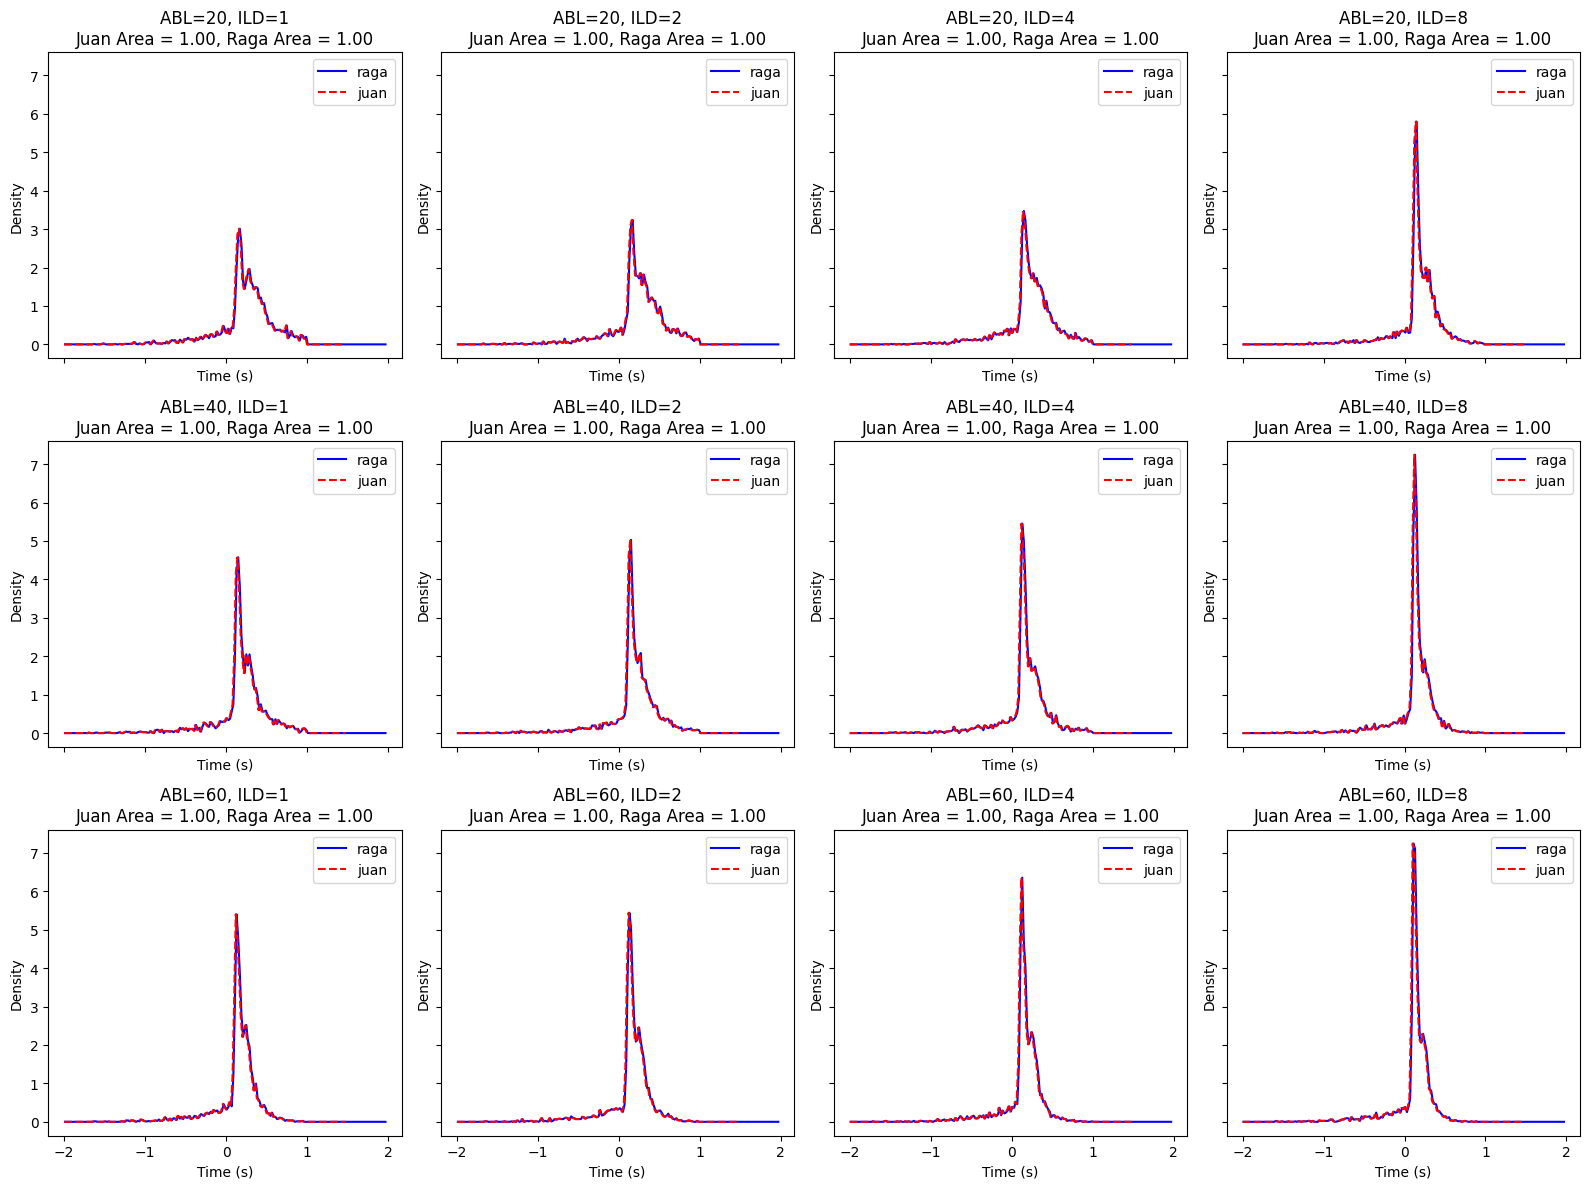

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import trapz

# Assuming ABL_test, ILD_test, data_df_led_off_with_aborts, xx, and hcs are already defined

# Create a 3x4 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12), sharex=True, sharey=True)

bins = np.arange(-2, 2, 0.02)
t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])

for ABL_i in range(3):
    for ILD_i in range(4):
        ax = axes[ABL_i, ILD_i]

        ABL = ABL_test[ABL_i]
        ILD = ILD_test[ILD_i]

        data_pd = data_df_led_off_with_aborts[
            (data_df_led_off_with_aborts['ABL'] == ABL) & 
            (data_df_led_off_with_aborts['ILD'].isin([ILD, -ILD]))
        ]
        data_rt = data_pd['rt'] - data_pd['t_stim']
        data_rt_hist, _ = np.histogram(data_rt, density=True, bins=bins)

        # Plot the two curves
        ax.plot(t_pts, data_rt_hist, label='raga', color='b')
        ax.plot(xx[:-1], hcs[ABL_i, ILD_i].squeeze(), color='r', ls='--', label='juan')
        ax.legend()

        # Calculate areas using trapz
        area_juan = trapz(hcs[ABL_i, ILD_i].squeeze(), xx[:-1])
        area_raga = trapz(data_rt_hist, t_pts)

        ax.set_title(f'ABL={ABL}, ILD={ILD}\nJuan Area = {area_juan:.2f}, Raga Area = {area_raga:.2f}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Density')

plt.tight_layout()
plt.show()


# theory

In [27]:
# Proactive params
V_A = 1.6
theta_A = 2.53
V_A_post_LED = V_A # LED OFF

# delays
t_A_aff = -0.187
t_E_aff = 0.075
del_go = 0.12

Z_E = 0
K_max = 10

# LED off - no noise
rate_lambda = 0.12
noise = 0

T_0_mean = 0.8900893454049942 * 1e-3
theta_E_mean = 30.800233833604512

In [28]:
import os
def psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change_M3_delGO(V_A, theta_A, ABL_arr, ILD_arr, rate_lambda, T_0, theta_E, Z_E, t_A_aff, t_E_aff, \
                                t_stim_and_led_tuple, new_V_A, new_noise, T0_factor, iter_num, N_print, is_LED_trial, del_go, dt):
    ABL = random.choice(ABL_arr)
    ILD = random.choice(ILD_arr)
    
    # random element from t_stim_and_led_tuple
    t_stim, t_led = t_stim_and_led_tuple

    # print after every N_print iterations
    if iter_num % N_print == 0:
        print(f'os id: {os.getpid()}, In iter_num: {iter_num}, ABL: {ABL}, ILD: {ILD}, t_stim: {t_stim}')

    choice, rt, is_act = simulate_psiam_tied_noise_change_no_L_T0_factor_M3_delGO(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, is_LED_trial, t_led, new_V_A, new_noise, T0_factor, del_go, dt)
    return {'choice': choice, 'rt': rt, 'is_act': is_act ,'ABL': ABL, 'ILD': ILD, 't_stim': t_stim, 't_led': t_led, 'is_LED_trial': is_LED_trial}

def simulate_psiam_tied_noise_change_no_L_T0_factor_M3_delGO(V_A, theta_A, ABL, ILD, rate_lambda, T_0, theta_E, Z_E, t_stim, t_A_aff, t_E_aff, is_LED_trial, t_led, new_V_A, new_noise, T0_factor, del_go, dt):
    AI = 0; DV = Z_E; t = t_A_aff; dB = dt**0.5
    
    chi = 17.37; q_e = 1
    theta = theta_E * q_e

    mu = (2*q_e/T_0) * (10**(rate_lambda * ABL/20)) * np.sinh(rate_lambda * ILD/chi)
    sigma = np.sqrt( (2*(q_e**2)/T_0) * (10**(rate_lambda * ABL/20)) * np.cosh(rate_lambda * ILD/ chi) )

    # firing rates decrease
    new_T0 = T_0 * T0_factor
    # mu changes with firing rate
    new_mu = (2*q_e/new_T0) * (10**(rate_lambda * ABL/20)) * np.sinh(rate_lambda * ILD/chi)
    # sigma changes with firing rate
    new_sigma = np.sqrt( (2*(q_e**2)/new_T0) * (10**(rate_lambda * ABL/20)) * np.cosh(rate_lambda * ILD/ chi) )
    new_sigma = np.sqrt(new_sigma**2 + new_noise**2)

    is_act = 0
    while True:
        if t >= t_led and is_LED_trial:
            mu = new_mu
            sigma = new_sigma
            V_A = new_V_A
        
        AI += V_A*dt + np.random.normal(0, dB)

        if t > t_stim + t_E_aff:
            DV += mu*dt + sigma*np.random.normal(0, dB)
        
        
        t += dt
        
        if DV >= theta:
            choice = +1; RT = t
            break
        elif DV <= -theta:
            choice = -1; RT = t
            break
        
        if AI >= theta_A:
            is_act = 1
            AI_hit_time = t
            did_EA_hit = 0
            # if t*dt > t_stim - t_motor:
            while t <= (AI_hit_time + del_go):#  u can process evidence till stim plays
                if t > t_stim + t_E_aff: # Evid accum wil begin only after stim starts and afferent delay
                    if t >= t_led and is_LED_trial:
                        mu = new_mu
                        sigma = new_sigma
                        V_A = new_V_A

                    DV += mu*dt + sigma*np.random.normal(0, dB)
                    if DV >= theta:
                        DV = theta
                        did_EA_hit = 1
                        break
                    elif DV <= -theta:
                        DV = -theta
                        did_EA_hit = -1
                        break
                t += dt
            
            break
        
        
    if is_act == 1:
        RT = AI_hit_time
        if did_EA_hit == 0:
            randomly_choose_up = np.random.rand() >= 0.5
            if randomly_choose_up:
                choice = 1
            else:
                choice = -1
        else:
            choice = did_EA_hit
               
    
    return choice, RT, is_act



In [30]:
# from tqdm.notebook import tqdm
# from joblib import Parallel, delayed

# N_sim = int(1e6)
# N_print = int(N_sim/5)
# is_LED_trial = True
# dt = 1e-4
# ABL_arr = df['ABL'].unique(); ABL_arr.sort()
# ILD_arr = df['ILD'].unique(); ILD_arr.sort()

# t_stim_and_led_tuple = [(0.6, row['intended_fix'] - row['LED_onset_time']) for _, row in df.iterrows()]
# sampled_indices = np.random.choice(len(t_stim_and_led_tuple), N_sim)
# t_stim_and_led_tuple_samples = [t_stim_and_led_tuple[i] for i in sampled_indices]

# sim_results = Parallel(n_jobs=30)(delayed(psiam_tied_data_gen_wrapper_noise_change_no_L_T0_change_M3_delGO)(V_A, theta_A, ABL_arr, ILD_arr,\
#                                                                                         rate_lambda, T_0_mean, theta_E_mean, Z_E, \
#                                                                                             t_A_aff, t_E_aff,\
#                                                                                     t_stim_and_led_tuple_samples[iter_num], \
#                                                                         V_A_post_LED, noise_mean, 1, iter_num, N_print, is_LED_trial, del_go, dt) \
#                                                                               for iter_num in tqdm(range(N_sim)))

In [31]:
import pickle
with open('compare_theory_with_juan_sim_results.pkl', 'rb') as f:
    sim_results = pickle.load(f)

In [32]:
sim_results_df = pd.DataFrame(sim_results)
sim_results_df['correct'] = sim_results_df.apply(
    lambda row: 1 if row['ILD'] * row['choice'] > 0 else 0,
    axis=1
)

In [33]:
# > 1s are removed 
sim_results_df = sim_results_df[sim_results_df['rt'] - sim_results_df['t_stim'] < 1] 

# remove aborts < 0.3
sim_results_df_with_aborts = sim_results_df[ ~( (sim_results_df['rt'] < sim_results_df['t_stim']) & (sim_results_df['rt'] < 0.3) ) ]

In [34]:
import scipy.io

# Load the .mat file
data = scipy.io.loadmat('dist_to_compare.mat')

# Assuming your .mat file contains variables 'xx' and 'hcs'
xx = data['tt'].squeeze()  # Ensure xx is a 1D array
hcs = data['f_t']          # hcs might be a 2D array or a cell-like structure

ABL_test = [20, 40, 60]
ILD_test = [1, 2, 4, 8]

# for ABL_i in range(3):
#     for ILD_i in range(4):
#         ABL = ABL_test[ABL_i]
#         ILD = ILD_test[ILD_i]

#         data_pd = sim_results_df_with_aborts[(sim_results_df_with_aborts['ABL'] == ABL) & (sim_results_df_with_aborts['ILD'].isin([ILD, -ILD]))]
#         data_rt = data_pd['rt'] - data_pd['t_stim']

#         bins = np.arange(-2, 2, 0.02)
#         t_pts = bins[:-1] + 0.5*(bins[1] - bins[0])
#         data_rt_hist, _ = np.histogram(data_rt, density=True, bins=bins)

#         plt.figure()
#         # mine
#         plt.plot(t_pts, data_rt_hist, label=f'raga', color='b')
#         # Juan
#         plt.plot(xx, hcs[ABL_i, ILD_i].squeeze(), color='r', ls='--', label='juan')
#         plt.legend()
        
#         area_juan = trapz(hcs[ABL_i, ILD_i].squeeze(), xx)
#         area_raga = trapz(data_rt_hist, t_pts)
        
#         plt.title(f'ABL={ABL_test[ABL_i]}, ILD={ILD_test[ILD_i]}, Juan Area = {area_juan:.2f}, Raga Area = {area_raga: .2f}')

#         plt.show()


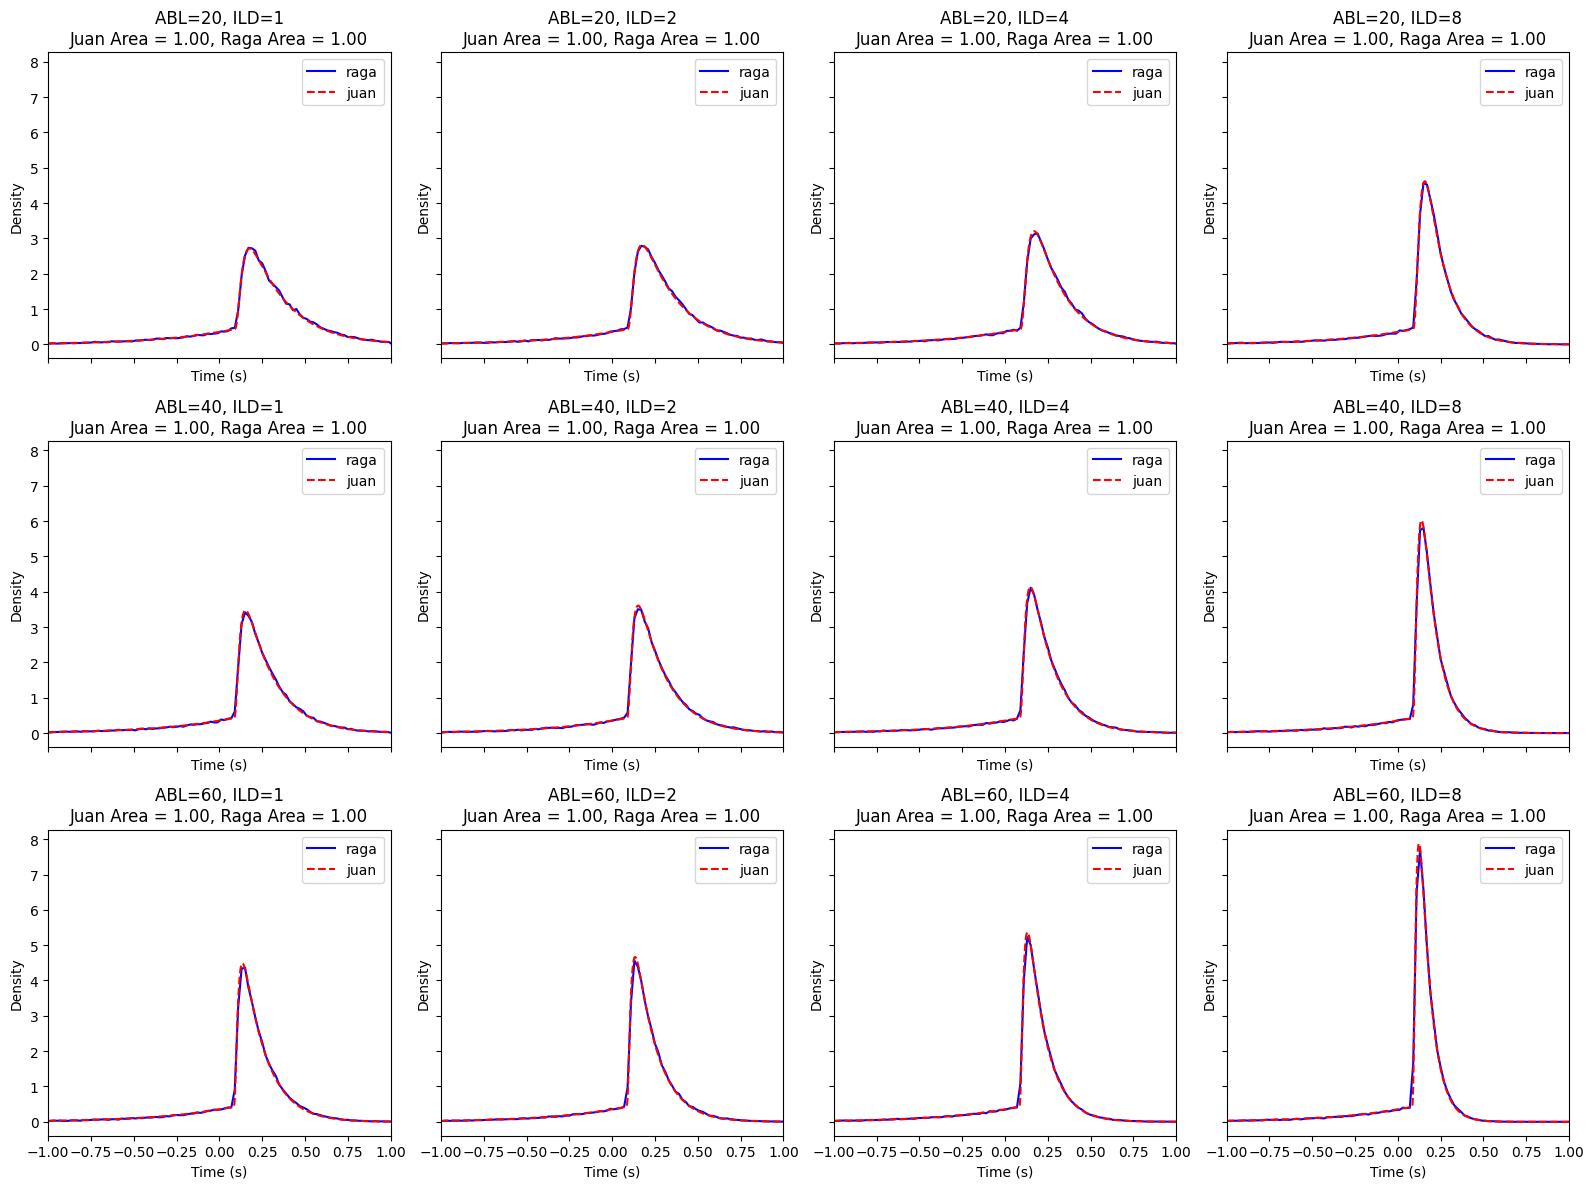

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.integrate import trapezoid as trapz

# Load the .mat file
mat_data = loadmat('dist_to_compare.mat')

# Assuming your .mat file contains variables 'tt' and 'f_t'
xx = mat_data['tt'].squeeze()  # Ensure xx is a 1D array
hcs = mat_data['f_t']          # hcs is assumed to be a 2D array-like structure

# Define ABL and ILD test values
ABL_test = [20, 40, 60]
ILD_test = [1, 2, 4, 8]

# Create a 3x4 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12), sharex=True, sharey=True)

# Define bins and time points for histogram computation
bins = np.arange(-2, 2, 0.02)
t_pts = bins[:-1] + 0.5 * (bins[1] - bins[0])

# Loop over ABL and ILD conditions
for ABL_i in range(3):
    for ILD_i in range(4):
        ax = axes[ABL_i, ILD_i]

        ABL = ABL_test[ABL_i]
        ILD = ILD_test[ILD_i]

        # Filter your DataFrame for current ABL and ILD values (including the negative ILD)
        data_pd = sim_results_df_with_aborts[
            (sim_results_df_with_aborts['ABL'] == ABL) &
            (sim_results_df_with_aborts['ILD'].isin([ILD, -ILD]))
        ]
        # Compute reaction times relative to stimulus time
        data_rt = data_pd['rt'] - data_pd['t_stim']

        # Compute histogram for the current data
        data_rt_hist, _ = np.histogram(data_rt, density=True, bins=bins)

        # Plot "raga" histogram using t_pts
        ax.plot(t_pts, data_rt_hist, label='raga', color='b')
        # Plot "juan" histogram loaded from the .mat file using xx as the x-axis
        ax.plot(xx, hcs[ABL_i, ILD_i].squeeze(), color='r', ls='--', label='juan')
        ax.legend()

        # Calculate area under the curves
        area_juan = trapz(hcs[ABL_i, ILD_i].squeeze(), xx)
        area_raga = trapz(data_rt_hist, t_pts)

        ax.set_title(f'ABL={ABL}, ILD={ILD}\nJuan Area = {area_juan:.2f}, Raga Area = {area_raga:.2f}')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Density')
        ax.set_xlim(-1, 1)

plt.tight_layout()
plt.show()
